### 1. Setup & Imports

In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 96.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb  # PhysioNet's Waveform Database library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

### Download dataset

In [3]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
!mv physionet.org/files/mitdb/1.0.0 ./mitdb  # Move files to a simpler path
!rm -r physionet.org  # Clean up

Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2025-08-27 16:10:12 (614 MB/s) - ‘physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2025-08-27 16:10:12--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M   418KB/s    in 4.5s    

2025-08-27 16:10:17 (419 KB/s) - ‘physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2025-08-27 16:10:17--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 258 [text/plain]
Saving to: ‘physionet.o

### 2. Load MIT-BIH Data

In [5]:
# List all records (e.g., '100', '101', ...)
records = [f.split('.')[0] for f in os.listdir('mitdb') if f.endswith('.dat')]

# Load signals and annotations
def load_ecg_record(record_name):
    signal = wfdb.rdrecord(f'mitdb/{record_name}').p_signal[:, 0]  # Lead II (MLII)
    annotation = wfdb.rdann(f'mitdb/{record_name}', 'atr')
    return signal, annotation

# Example: Load record
ecg, ann = load_ecg_record('100')
print(len(ecg))

650000


In [6]:
# List all records (e.g., '100', '101', ...)
records = [f.split('.')[0] for f in os.listdir('mitdb') if f.endswith('.dat')]

import numpy as np
import pandas as pd
import wfdb

def load_ecg_with_labels(record_name, window_size=256):
    # Load ECG and annotations
    signal = wfdb.rdrecord(f'mitdb/{record_name}').p_signal[:, 0]  # Lead II
    annotation = wfdb.rdann(f'mitdb/{record_name}', 'atr')

    segments = []
    labels = []

    # Loop over signal in fixed-size windows
    for start in range(0, len(signal) - window_size, window_size):
        end = start + window_size
        segment = signal[start:end]

        # Find beats within this window
        beat_indices = np.where((annotation.sample >= start) & (annotation.sample < end))[0]
        beat_labels = [annotation.symbol[i] for i in beat_indices]

        # Label as anomaly if any beat != 'N'
        label = 0 if all(b == 'N' for b in beat_labels) else 1

        segments.append(segment)
        labels.append(label)

    # Convert to DataFrame
    df = pd.DataFrame({
        "ECG_Segment": segments,
        "Label": labels
    })

    return df

df = load_ecg_with_labels('100', window_size=256)
print(df.head())
print(df['Label'].value_counts())


                                         ECG_Segment  Label
0  [-0.145, -0.145, -0.145, -0.145, -0.145, -0.14...      1
1  [-0.295, -0.31, -0.29, -0.295, -0.3, -0.305, -...      0
2  [-0.315, -0.305, -0.315, -0.315, -0.31, -0.295...      0
3  [-0.36, -0.34, -0.335, -0.33, -0.335, -0.335, ...      0
4  [-0.39, -0.39, -0.365, -0.37, -0.375, -0.385, ...      0
Label
0    2504
1      35
Name: count, dtype: int64


### Basic EDA

In [7]:
symbols, counts = np.unique(ann.symbol, return_counts=True)
readable_counts = {str(sym): int(cnt) for sym, cnt in zip(symbols, counts)}
print("Symbols and their counts: ",readable_counts)

Symbols and their counts:  {'+': 1, 'A': 33, 'N': 2239, 'V': 1}


In [8]:
# ------------------------------
# Show dataset distribution
# ------------------------------
total_samples = len(df['Label'])
normal_samples = np.sum(df['Label'] == 0)
anomaly_samples = np.sum(df['Label'] == 1)

print(f"Total ECG Segments: {total_samples}")
print(f"Normal Segments: {normal_samples}")
print(f"Anomaly Segments: {anomaly_samples}")


Total ECG Segments: 2539
Normal Segments: 2504
Anomaly Segments: 35


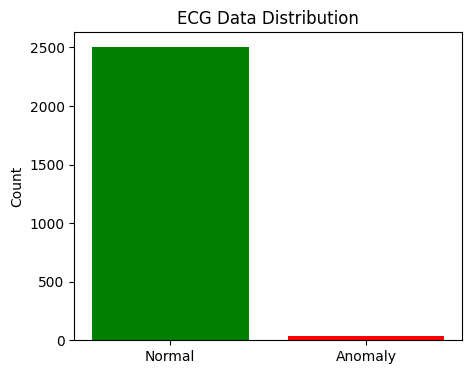

In [9]:
plt.figure(figsize=(5,4))
plt.bar(["Normal", "Anomaly"], [normal_samples, anomaly_samples], color=["green", "red"])
plt.title("ECG Data Distribution")
plt.ylabel("Count")
plt.show()

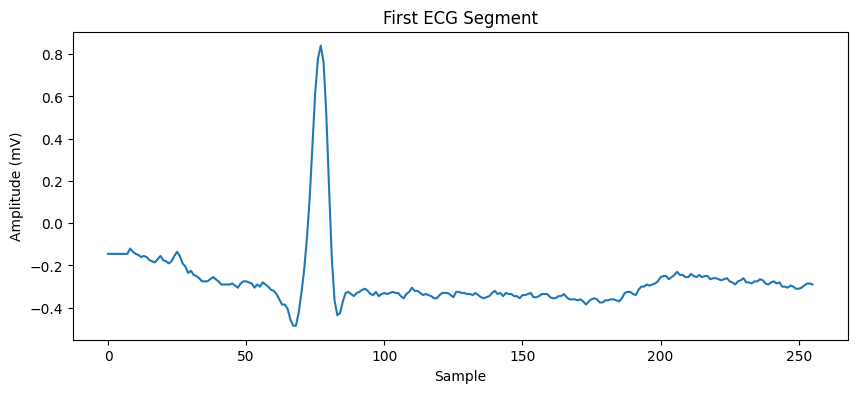

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Pick first segment and flatten
segment = df["ECG_Segment"].iloc[0]  # This is already a 1D array
plt.figure(figsize=(10, 4))
plt.plot(segment)
plt.title("First ECG Segment")
plt.xlabel("Sample")
plt.ylabel("Amplitude (mV)")
plt.show()

In [11]:
# List all .dat files (each corresponds to one record)
records = [f.split('.')[0] for f in os.listdir('mitdb') if f.endswith('.dat')]
print(f"Found {len(records)} records: {records[:5]}...")

Found 48 records: ['108', '221', '233', '100', '234']...


### 3. Preprocessing

3.1 Segment ECG into Normal Beats

In [12]:
all_segments = []
window_size = 256

for record in records:
    try:
        # Load ECG and annotations
        ecg, ann = load_ecg_record(record)  # Your existing function

        # Extract segments (normal beats 'N' + other valid labels)
        normal_labels = ['N', 'L', 'R', 'e', 'j']  # Normal variants
        r_peaks = ann.sample[np.isin(ann.symbol, normal_labels)]

        for peak in r_peaks:
            start = max(0, peak - window_size//2)
            end = start + window_size
            if end <= len(ecg):
                segment = ecg[start:end]
                all_segments.append(segment)
    except Exception as e:
        print(f"⚠️ Error processing {record}: {e}")
        continue

all_segments = np.array(all_segments)
print(f"✅ Total segments extracted: {len(all_segments)}")

✅ Total segments extracted: 90610


In [13]:
# Create DataFrame for beats
df_beats = pd.DataFrame(all_segments)

print("\nShape of segmented beats array:", df_beats.shape)
print("First beat segment:\n", df_beats.iloc[0])


Shape of segmented beats array: (90610, 256)
First beat segment:
 0     -0.125
1     -0.125
2     -0.125
3     -0.125
4     -0.125
       ...  
251   -0.305
252   -0.290
253   -0.275
254   -0.285
255   -0.310
Name: 0, Length: 256, dtype: float64


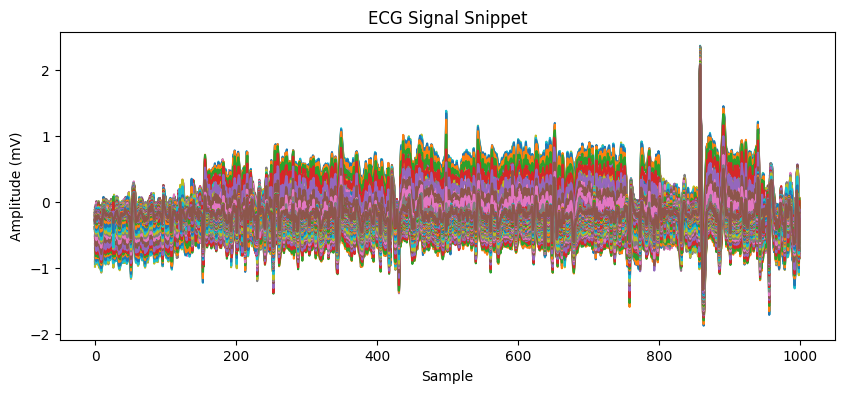

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(df_beats[:1000])
plt.title("ECG Signal Snippet")
plt.xlabel("Sample")
plt.ylabel("Amplitude (mV)")
plt.show()

3.2 Normalize Data

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Normalize all segments together
scaler = MinMaxScaler(feature_range=(-1, 1))
segments_normalized = scaler.fit_transform(all_segments.reshape(-1, window_size)).reshape(-1, window_size, 1)

In [16]:
segments_normalized[:10]

array([[[-0.02393747],
        [-0.02393747],
        [-0.02393747],
        ...,
        [-0.05324866],
        [-0.05520274],
        [-0.06008793]],

       [[-0.06008793],
        [-0.06106497],
        [-0.06692721],
        ...,
        [-0.04152418],
        [-0.04347826],
        [-0.04054714]],

       [[-0.05813385],
        [-0.05715681],
        [-0.05911089],
        ...,
        [-0.04347826],
        [-0.04543234],
        [-0.05129458]],

       ...,

       [[-0.05813385],
        [-0.06008793],
        [-0.06106497],
        ...,
        [-0.05324866],
        [-0.0542257 ],
        [-0.0493405 ]],

       [[-0.06595017],
        [-0.06790425],
        [-0.07083537],
        ...,
        [-0.05129458],
        [-0.05324866],
        [-0.05520274]],

       [[-0.06692721],
        [-0.06692721],
        [-0.06790425],
        ...,
        [-0.06888129],
        [-0.07278945],
        [-0.06985833]]])

### Dataset before and after preprocessing

In [30]:
import numpy as np
import pandas as pd
import wfdb
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# Load raw ECG signal (Record 100)
# -----------------------------
record_name = "100"
signal = wfdb.rdrecord(f"mitdb/{record_name}").p_signal[:, 0]  # Lead II
annotation = wfdb.rdann(f"mitdb/{record_name}", "atr")

# Create DataFrame for raw dataset (first 20 samples for display)
raw_df = pd.DataFrame({
    "Index": range(20),
    "ECG_Value": signal[:20],
    "Annotation": [annotation.symbol[i] if i < len(annotation.symbol) else None for i in range(20)]
})

print("Raw Dataset (Record 100 - first 10 samples):")
display(raw_df.head(10))
print("\n\n")
# -----------------------------
# Preprocessing: Segment & Label
# -----------------------------
window_size = 256
df_preprocessed = load_ecg_with_labels(record_name="100", window_size=window_size)

# Keep only NORMAL segments
df_normal = df_preprocessed[df_preprocessed["Label"] == 0].reset_index(drop=True)

# -----------------------------
# Normalization (Min-Max scaling to [-1, 1])
# -----------------------------
scaler = MinMaxScaler(feature_range=(-1, 1))
segments_array = np.stack(df_normal["ECG_Segment"].values)  # shape: (n_samples, window_size)
segments_normalized = scaler.fit_transform(segments_array)

# Add normalized data back into DataFrame
df_normal["Normalized_Segment"] = list(segments_normalized)
# --- create a clean table (first 10 values of each normalized segment) ---
normalized_df = pd.DataFrame(
    segments_normalized[:, :10],  # take first 10 values for readability
    columns=[f"Val_{i+1}" for i in range(10)]
)

# (Optional) Add the Label column for clarity
normalized_df["Label"] = df_normal["Label"].values
print("Preprocessed ECG Segments (showing first 10 values of each segment):")
display(normalized_df.head(10))


Raw Dataset (Record 100 - first 10 samples):


Index  ECG_Value Annotation
0      0     -0.145          +
1      1     -0.145          N
2      2     -0.145          N
3      3     -0.145          N
4      4     -0.145          N
5      5     -0.145          N
6      6     -0.145          N
7      7     -0.145          N
8      8     -0.120          A
9      9     -0.135          N




Preprocessed ECG Segments (showing first 10 values of each segment):


Val_1     Val_2     Val_3     Val_4     Val_5     Val_6     Val_7  \
0 -0.618557 -0.638191 -0.623037 -0.636856 -0.624021 -0.615789 -0.612245   
1 -0.639175 -0.633166 -0.649215 -0.658537 -0.634465 -0.605263 -0.591837   
2 -0.685567 -0.668342 -0.670157 -0.674797 -0.660574 -0.647368 -0.627551   
3 -0.716495 -0.718593 -0.701571 -0.718157 -0.702350 -0.700000 -0.693878   
4 -0.737113 -0.738693 -0.759162 -0.766938 -0.733681 -0.710526 -0.698980   
5 -0.716495 -0.718593 -0.743455 -0.756098 -0.744125 -0.726316 -0.698980   
6 -0.340206 -0.663317 -0.821990 -0.826558 -0.744125 -0.689474 -0.668367   
7 -0.690722 -0.688442 -0.691099 -0.707317 -0.686684 -0.663158 -0.642857   
8 -0.659794 -0.658291 -0.649215 -0.663957 -0.644909 -0.647368 -0.637755   
9 -0.675258 -0.678392 -0.685864 -0.680217 -0.644909 -0.615789 -0.617347   

      Val_8     Val_9    Val_10  Label  
0 -0.601050 -0.590426 -0.609065      0  
1 -0.580052 -0.590426 -0.631728      0  
2 -0.595801 -0.585106 -0.614731      0  
3 -0.669291 -0.659574 -0.682720      0  
4 -0.674541 -0.686170 -0.716714      0  
5 -0.674541 -0.686170 -0.739377      0  
6 -0.664042 -0.686170 -0.699717      0  
7 -0.622047 -0.627660 -0.671388      0  
8 -0.601050 -0.606383 -0.631728      0  
9 -0.590551 -0.601064 -0.614731      0

### Display Anomaly data

In [31]:
import pandas as pd
import numpy as np

# Assuming 'df' contains record 100 ECG data with 'ECG_Segment' and 'Label' columns
# Label = 0 -> Normal, 1 -> Anomalous

# --- Filter anomalous segments ---
df_anomaly = df[df["Label"] == 1].reset_index(drop=True)

# --- Convert segments into array ---
segments_array = np.stack(df_anomaly["ECG_Segment"].values)

# --- Create DataFrame (show first 10 values for readability) ---
anomaly_df = pd.DataFrame(
    segments_array[:, :10],  # first 10 values of each anomalous segment
    columns=[f"Val_{i+1}" for i in range(10)]
)

# Add annotation/label info
anomaly_df["Label"] = df_anomaly["Label"].values

print("Anomalous ECG Segments from Record 100 (first 10 values shown):")
display(anomaly_df.head(10))


Anomalous ECG Segments from Record 100 (first 10 values shown):


Val_1  Val_2  Val_3  Val_4  Val_5  Val_6  Val_7  Val_8  Val_9  Val_10  \
0 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.120  -0.135   
1 -0.355 -0.365 -0.370 -0.405 -0.445 -0.480 -0.495 -0.520 -0.535  -0.505   
2 -0.300 -0.305 -0.310 -0.320 -0.330 -0.345 -0.350 -0.345 -0.340  -0.335   
3 -0.420 -0.435 -0.475 -0.510 -0.535 -0.580 -0.610 -0.585 -0.485  -0.335   
4 -0.185 -0.190 -0.225 -0.250 -0.265 -0.285 -0.295 -0.300 -0.305  -0.320   
5 -0.275 -0.260 -0.230 -0.195 -0.170 -0.150 -0.140 -0.145 -0.135  -0.120   
6  0.820  0.670  0.335 -0.050 -0.360 -0.505 -0.490 -0.440 -0.395  -0.385   
7 -0.385 -0.405 -0.395 -0.390 -0.370 -0.365 -0.375 -0.375 -0.365  -0.370   
8 -0.405 -0.420 -0.415 -0.405 -0.405 -0.420 -0.425 -0.430 -0.420  -0.410   
9 -0.315 -0.310 -0.305 -0.300 -0.300 -0.310 -0.310 -0.310 -0.305  -0.305   

   Label  
0      1  
1      1  
2      1  
3      1  
4      1  
5      1  
6      1  
7      1  
8      1  
9      1

3.3 Train-Test Split

In [ ]:
X_train, X_test = train_test_split(segments_normalized, test_size=0.1, random_state=42)
X_train = X_train.reshape(-1, window_size, 1)  # Add channel dim for Conv1D
X_test = X_test.reshape(-1, window_size, 1)

### 4. Build GAN Model

In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Conv1DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

def build_generator(latent_dim=100, window_size=256):
    noise = Input(shape=(latent_dim,))

    x = Dense(64)(noise)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(window_size)(x)
    x = Reshape((window_size, 1))(x)

    return Model(noise, x)

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,576 (189.75 KB)

 Trainable params: 48,192 (188.25 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.layers import (Input, Conv1D, LeakyReLU, LayerNormalization,
                                    Dropout, GlobalMaxPooling1D, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_stable_discriminator(window_size=256):
    ecg_input = Input(shape=(window_size, 1))

    # Feature extraction with spectral normalization
    x = Conv1D(64, 5, strides=2, padding='same')(ecg_input)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)  # Better than BatchNorm for GANs
    x = Dropout(0.3)(x)

    x = Conv1D(128, 5, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, 5, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)

    # Decision layer
    x = GlobalMaxPooling1D()(x)  # More stable than Flatten()
    x = Dense(1, activation='sigmoid')(x)

    discriminator = Model(ecg_input, x)

    # Use lower learning rate for discriminator
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy',
                         optimizer=optimizer,
                         metrics=['accuracy'])
    return discriminator

# Usage
discriminator = build_stable_discriminator(window_size=256)
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 128, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 64, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 32, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,721 (807.50 KB)

 Trainable params: 206,721 (807.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Freeze discriminator during generator training
discriminator.trainable = False

# Connect generator -> discriminator
gan_input = Input(shape=(100,))
fake_ecg = generator(gan_input)
gan_output = discriminator(fake_ecg)

# Compile GAN
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

### 5. Train the Model


In [ ]:
import numpy as np
from tensorflow.keras.optimizers import Adam

def train_gan(X_train, generator, discriminator, gan,
             epochs, batch_size, window_size=256):
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Select random real ECGs
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_ecgs = X_train[idx]

        # Generate fake ECGs
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_ecgs = generator.predict(noise)

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_ecgs, valid)
        d_loss_fake = discriminator.train_on_batch(fake_ecgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, valid)

        # Print progress
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | D Loss: {d_loss[0]:.4f} | D Acc: {100*d_loss[1]:.2f}% | G Loss: {g_loss:.4f}")


# Run training with your existing data
train_gan(
    X_train=X_train,  # Your preprocessed training data (shape: [n_samples, window_size, 1])
    generator=generator,
    discriminator=discriminator,
    gan=gan,
    epochs=1000,
    batch_size=64,     # Adjust based on GPU memory
    window_size=256    # Must match your segment length
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: 0.8612 | D Acc: 37.50% | G Loss: 1.4259
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14

### 6. Reconstruction and Anomaly Detection

6.1 Compute Reconstruction Error


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from scipy.optimize import minimize

# Force TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("✅ Using GPU for TensorFlow operations")
    except:
        pass
else:
    print("⚠️ No GPU found — running on CPU")

def ecg_to_latent(real_ecg, generator, iterations=500):
    """Find latent code that best reconstructs the input ECG using GPU for predictions"""
    latent_dim = generator.input_shape[1]
    real_ecg = real_ecg.reshape(1, -1, 1).astype(np.float32)

    # Loss function to minimize
    def loss(z):
        z_tensor = tf.convert_to_tensor(z.reshape(1, latent_dim), dtype=tf.float32)
        generated = generator(z_tensor, training=False)  # GPU inference
        return float(tf.reduce_mean(tf.square(generated - real_ecg)).numpy())

    # Optimize latent vector (CPU)
    result = minimize(loss,
                      x0=np.random.randn(latent_dim),
                      method='L-BFGS-B',
                      options={'maxiter': iterations})
    return result.x

def reconstruct_with_gan(ecg_signal, generator):
    """Generate reconstructed ECG using GPU inference"""
    latent_code = ecg_to_latent(ecg_signal, generator)
    z_tensor = tf.convert_to_tensor(latent_code.reshape(1, -1), dtype=tf.float32)
    reconstructed = generator(z_tensor, training=False)
    return reconstructed.numpy()[0]

# Example usage
original_ecg = X_test[0]  # Your normalized ECG segment
reconstructed = reconstruct_with_gan(original_ecg, generator)
mse = np.mean((original_ecg - reconstructed) ** 2)
print(f"Reconstruction MSE: {mse:.4f}")


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

6.2 Visualize Reconstruction

567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━

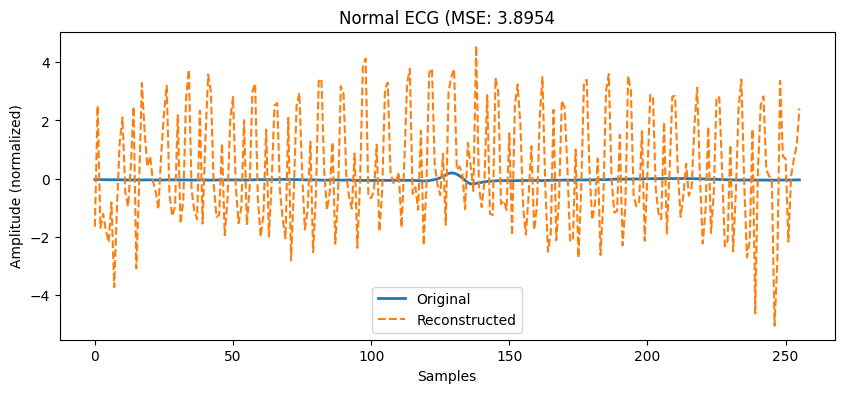

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/ste

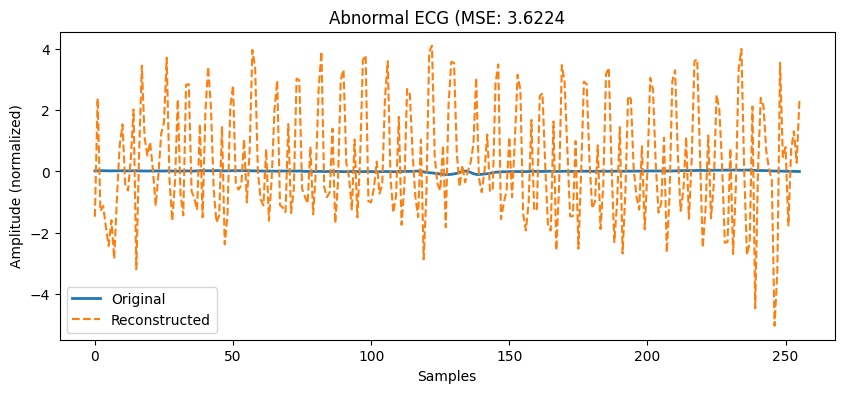

In [ ]:
import matplotlib.pyplot as plt

def plot_reconstruction(original, reconstructed, title=""):
    plt.figure(figsize=(10,4))
    plt.plot(original.flatten(), label='Original', linewidth=2)
    plt.plot(reconstructed.flatten(), label='Reconstructed', linestyle='--')
    plt.title(f"{title} (MSE: {np.mean((original-reconstructed)**2):.4f}")
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (normalized)')
    plt.show()

# Visualize normal vs abnormal reconstructions
normal_ecg = X_test[0]  # Replace with your normal ECG
abnormal_ecg = X_test[np.argmax(discriminator.predict(X_test))]  # Most anomalous

for ecg, label in [(normal_ecg, "Normal ECG"),
                   (abnormal_ecg, "Abnormal ECG")]:
    reconstructed = reconstruct_with_gan(ecg, generator)
    plot_reconstruction(ecg, reconstructed, label)

6.3 Detect Anomalies

In [ ]:
def gan_anomaly_detector(ecg_signal, generator, discriminator, threshold=0.3):
    """Combined anomaly score using reconstruction error and discriminator"""
    # Reconstruction error
    reconstructed = reconstruct_with_gan(ecg_signal, generator)
    mse = np.mean((ecg_signal - reconstructed)**2)

    # Discriminator confidence
    realness = discriminator.predict(ecg_signal.reshape(1, -1, 1))[0][0]

    # Combined score (weighted)
    anomaly_score = 0.7*mse + 0.3*(1-realness)  # Adjust weights as needed

    if anomaly_score > threshold:
        print(f"🚨 Anomaly Detected (Score: {anomaly_score:.3f})")
        print(f" - Reconstruction MSE: {mse:.4f}")
        print(f" - Discriminator 'real' confidence: {realness*100:.1f}%")
    else:
        print(f"✅ Normal ECG (Score: {anomaly_score:.3f})")

    return anomaly_score

# Example usage
abnormal_ecg, _ = load_ecg_record('124')
abnormal_segment = abnormal_ecg[1000:1000+256]  # Window of 256 samples
abnormal_segment = scaler.transform(abnormal_segment.reshape(1, -1)).reshape(1, 256, 1)
gan_anomaly_detector(abnormal_segment, generator, discriminator)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

np.float64(2.4568835705062453)

### 7. Save & Export

In [ ]:
generator.save('generator.h5')  # For later use

### Confusion matrix

Segments shape: (2539, 256)
Labels distribution  [normal, anomaly]: [2504   35]
Total Segments: 2539

Training set contains ONLY normal ECGs:
   X_train: 2253, y_train distribution: [2253]

Testing set contains normal + anomalies:
   X_test: 286, y_test distribution: [251  35]


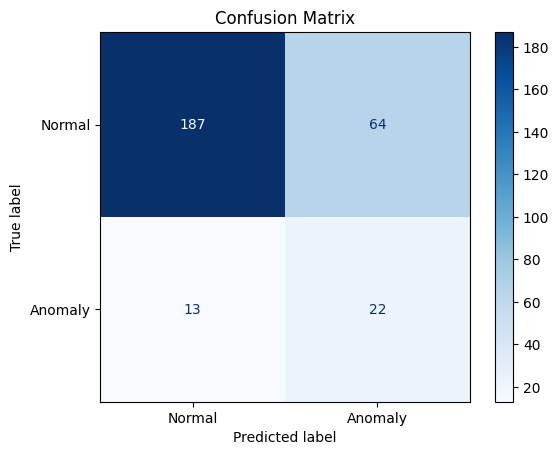

Accuracy:  0.7308
Precision: 0.2558
Recall:    0.6286
F1 Score:  0.3636


In [ ]:
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf

# ------------------------------
# 1. Load ECG Record + Annotation
# ------------------------------
def load_ecg_record(record_name):
    signal = wfdb.rdrecord(f"mitdb/{record_name}").p_signal[:, 0]  # Lead II (MLII)
    annotation = wfdb.rdann(f"mitdb/{record_name}", 'atr')
    return signal, annotation

# ------------------------------
# 2. Segment ECG & Create Labels
# ------------------------------
def get_labels_from_annotations(signal, ann, window_size=256):
    normal_beats = ['N']  # only 'N' considered normal
    labels = []
    segments = []

    for start in range(0, len(signal) - window_size, window_size):
        seg = signal[start:start+window_size]
        beat_indices = [i for i, s in enumerate(ann.sample) if start <= s < start+window_size]
        beat_symbols = [ann.symbol[i] for i in beat_indices]

        if any(sym not in normal_beats for sym in beat_symbols):
            label = 1   # anomaly
        else:
            label = 0   # normal

        segments.append(seg)
        labels.append(label)

    return np.array(segments), np.array(labels)

# ------------------------------
# 3. Load & Process Data
# ------------------------------
ecg, ann = load_ecg_record('100')  # Change record ID as needed
segments, labels = get_labels_from_annotations(ecg, ann, window_size=256)

print(f"Segments shape: {segments.shape}")
print(f"Labels distribution  [normal, anomaly]: {np.bincount(labels)}")
print(f"Total Segments: {len(segments)}")

# ------------------------------
# Train only on Normal ECGs
# ------------------------------
normal_indices = np.where(labels == 0)[0]
anomaly_indices = np.where(labels == 1)[0]

segments_normal = segments[normal_indices]
labels_normal = labels[normal_indices]

# Normalize (fit only on normal data)
scaler = StandardScaler()
segments_normalized = scaler.fit_transform(segments_normal)

# Train/test split for NORMAL data only
X_train, X_test_normal, y_train, y_test_normal = train_test_split(
    segments_normalized, labels_normal, test_size=0.1, random_state=42
)

# Keep anomalies only for testing
X_test_anomaly = segments[anomaly_indices]
y_test_anomaly = labels[anomaly_indices]

# Normalize anomalies using the same scaler
X_test_anomaly = scaler.transform(X_test_anomaly)

# Combine normal test + anomaly test
X_test = np.vstack([X_test_normal, X_test_anomaly])
y_test = np.hstack([y_test_normal, y_test_anomaly])

# Reshape for Conv1D
window_size = 256
X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

# Info
print(f"\nTraining set contains ONLY normal ECGs:")
print(f"   X_train: {len(X_train)}, y_train distribution: {np.bincount(y_train)}")

print(f"\nTesting set contains normal + anomalies:")
print(f"   X_test: {len(X_test)}, y_test distribution: {np.bincount(y_test)}")

# ------------------------------
# 4. Load Generator
# ------------------------------
generator = load_model("generator.h5", compile=False)

# ------------------------------
# 5. GPU-Optimized Reconstruction Function
# ------------------------------
def reconstruct_with_gan_gpu(ecg_signal, generator, steps=50, lr=0.05):
    latent_dim = generator.input_shape[1]
    target = tf.convert_to_tensor(ecg_signal.reshape(1, -1, 1), dtype=tf.float32)

    z = tf.Variable(tf.random.normal([1, latent_dim], dtype=tf.float32))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for _ in range(steps):
        with tf.GradientTape() as tape:
            generated = generator(z, training=False)
            loss = tf.reduce_mean(tf.square(generated - target))
        grads = tape.gradient(loss, [z])
        optimizer.apply_gradients(zip(grads, [z]))

    return generator(z, training=False)[0].numpy()

# ------------------------------
# 6. Compute Reconstruction Errors
# ------------------------------
errors = []
for i in range(len(X_test)):
    reconstructed = reconstruct_with_gan_gpu(X_test[i], generator, steps=50)
    mse = np.mean((X_test[i] - reconstructed)**2)
    errors.append(mse)
errors = np.array(errors)

# ------------------------------
# 7. Evaluation (Confusion Matrix & Metrics)
# ------------------------------
threshold = np.percentile(errors, 70)  # select threshold
y_pred = (errors > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)


print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
